In [1]:
from dgpsi import dgp, kernel, combine, lgp, path, emulator
import numpy as np
import csv
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

In [2]:
#total number of profiles
count=75446

In [3]:
#load the input value
x=np.loadtxt('xvalues')

In [7]:
#reshape the input value
x_reshape=x.reshape(count,210)

In [8]:
#get the cape value
f = csv.reader(open('cape.csv','r'))
list_y=[float(row[1]) for row in f]
array_y=np.array(list_y)
yy=array_y.reshape(-1,1)
# yy=np.log(1+yy)

In [9]:
#find the ratio of CAPE 0 and CAPE is not 0
x_binary=x_reshape.copy()
y_binary=array_y.copy()
y_binary[y_binary!=0]=1

In [10]:
len(y_binary[y_binary==0])/count

0.6266336187471834

In [11]:
#reshape the strcture to let the first 70 values are temperature, the second 70 are pressure 
#and last 70 are mixing ratio

xx_new=x.reshape(count,70,3)
xxx_new=[]
for e in xx_new:
    xxx_new.append(e[:,0])
    xxx_new.append(e[:,1])
    xxx_new.append(e[:,2])
    
xx_changed=np.array(xxx_new).reshape(count,210)

In [12]:
#find a subset
rate=500/count
sub_x,x_large,sub_y,y_large=train_test_split(xx_changed,yy,test_size=1-rate,random_state=42)

In [13]:
len(sub_y[sub_y==0])/500

0.608

In [15]:
# the function to construct emulator
# input: model
# return : emulator
def Construct_emulator(model):
    final_layer_obj=model.estimate()
    emu=emulator(final_layer_obj)
    return emu

In [17]:
# the function to make predictions
# input: emu(emulator), x_test(2-d np.array), N(integer): iterations
# return: mu(mean), var(variance), s(square root of variance),u(upperbound),l(lowerbound)
def predict(emu,x_test,n):
    mu,var=emu.predict(x=x_test, N=n, method='mean_var')
    s=np.sqrt(var)
    u=mu+2*s
    l=mu-2*s
    return mu,var,s,u,l

In [18]:
# reload file locally
def load_value(file):
    value=np.loadtxt(file)
    mu,var,s,u,l=value[:,0],value[:,1],value[:,2],value[:,3],value[:,4]
    return mu,var,s,u,l

In [23]:
# load x,y input
def load_data():
    x_train=np.loadtxt('dgpfile/pcaxtrain.txt')
    y_train=np.loadtxt('dgpfile/pcaytrain.txt').reshape(-1,1)
    x_test=np.loadtxt('dgpfile/pcaxtest.txt')
    y_test=np.loadtxt('dgpfile/pcaytest.txt').reshape(-1,1)
    return x_train,y_train,x_test,y_test

In [19]:
# find the subset
x_train,x_test,y_train,y_test=train_test_split(sub_x,sub_y,test_size=0.60,random_state=42)

In [20]:
data_set=(x_train,x_test,y_train,y_test)

In [21]:
np.savetxt('dgpfile/pcaxtrain.txt',data_set[0])
np.savetxt('dgpfile/pcaxtest.txt',data_set[1])
np.savetxt('dgpfile/pcaytrain.txt',data_set[2])
np.savetxt('dgpfile/pcaytest.txt',data_set[3])

In [24]:
x_train,y_train,x_test,y_test=load_data()

In [25]:
#PCA method
pca = PCA(0.99)
pca.fit(x_train)
x_train = pca.transform(x_train)
x_test= pca.transform(x_test)

In [26]:
# construct model with 5 nodes
layer1=[kernel(length=np.array([1]),name='sexp'),kernel(length=np.array([1]),name='sexp'),
        kernel(length=np.array([1]),name='sexp'),kernel(length=np.array([1]),name='sexp'),
        kernel(length=np.array([1]),name='sexp')]
layer2=[kernel(length=np.array([1]),name='sexp',scale_est=1,connect=np.arange(5))]
all_layer_5nodes_2layers_pca=combine(layer1,layer2)
model_5nodes_2layers_pca=dgp(x_train,[y_train],all_layer_5nodes_2layers_pca)

In [28]:
model_5nodes_2layers_pca.train(N=500)

Iteration 500: Layer 2: 100%|██████████| 500/500 [18:22<00:00,  2.21s/it]


In [29]:
#make predictions
emu_5nodes_2layers_pca=Construct_emulator(model_5nodes_2layers_pca)
mu,var,s,u,l=predict(emu_5nodes_2layers_pca,x_test,50)
np.savetxt('dgpfile/5node_2layers_pca',np.c_[mu,var,s,u,l])

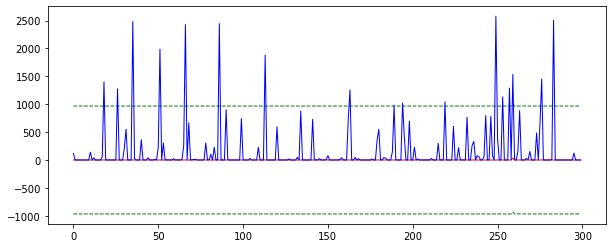

In [30]:
#plot predictions
mu,var,s,u,l=load_value('dgpfile/5node_2layers_pca')
y_test=load_data()[3]
plt.figure(figsize=(10,4))
p=plt.plot(mu,color='r',alpha=1,lw=1)
p1=plt.plot(u,'--',color='g',lw=1)
p1=plt.plot(l,'--',color='g',lw=1)
plt.plot(y_test,color='b',linewidth=1)

In [31]:
x_train,y_train,x_test,y_test=load_data()

In [32]:
# 2 layers, the first layer has 3 nodes, the second one has one node
layer1=[kernel(length=np.array([1]),name='sexp',input_dim=np.arange(70)),
        kernel(length=np.array([1]),name='sexp',input_dim=np.arange(70,140)),
        kernel(length=np.array([1]),name='sexp',input_dim=np.arange(140,210))]
layer2=[kernel(length=np.array([1]),name='sexp',scale_est=1,connect=np.arange(3))]
all_layer_3nodes_2layers=combine(layer1,layer2)
model_3nodes_2layers=dgp(x_train,[y_train],all_layer_3nodes_2layers)

In [33]:
model_3nodes_2layers.train(N=500)

Iteration 500: Layer 2: 100%|██████████| 500/500 [19:54<00:00,  2.39s/it]


In [34]:
#make predictions
emu_3nodes_2layers=Construct_emulator(model_3nodes_2layers)
mu,var,s,u,l=predict(emu_3nodes_2layers,x_test,50)
np.savetxt('dgpfile/data_3nodes_2layers.txt',np.c_[mu,var,s,u,l])

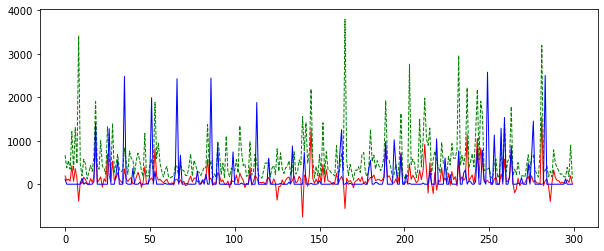

In [35]:
#plot predictions
mu,var,s,u,l=load_value('dgpfile/data_3nodes_2layers.txt')
y_test=load_data()[3]
plt.figure(figsize=(10,4))
p=plt.plot(mu,color='r',alpha=1,lw=1)
p1=plt.plot(u,'--',color='g',lw=1)
# p1=plt.plot(l,'--',color='g',lw=1)
plt.plot(y_test,color='b',linewidth=1)

Using log transform the y value

In [37]:
# log transform to y
x_train,y_train,x_test,y_test=load_data()
y_train=np.log(y_train+1)
y_test=np.log(y_test+1)

In [38]:
#pca metod
pca = PCA(0.99)
pca.fit(x_train)
x_train = pca.transform(x_train)
x_test= pca.transform(x_test)

In [46]:
#construct the model with 5nodes
layer1=[kernel(length=np.array([1]),name='sexp'),kernel(length=np.array([1]),name='sexp'),
        kernel(length=np.array([1]),name='sexp'),kernel(length=np.array([1]),name='sexp'),
        kernel(length=np.array([1]),name='sexp')]
layer2=[kernel(length=np.array([1]),name='sexp',scale_est=1,connect=np.arange(5))]
all_layer_5nodes_2layers_pca=combine(layer1,layer2)
model_5nodes_2layers_pca=dgp(x_train,[y_train],all_layer_5nodes_2layers_pca)

In [47]:
model_5nodes_2layers_pca.train(N=500)

Iteration 500: Layer 2: 100%|██████████| 500/500 [20:58<00:00,  2.52s/it]


In [48]:
#make predictions
emu_5nodes_2layers_pca=Construct_emulator(model_5nodes_2layers_pca)
mu,var,s,u,l=predict(emu_5nodes_2layers_pca,x_test,50)
np.savetxt('dgpfile/5node_2layers_pca_log',np.c_[mu,var,s,u,l])

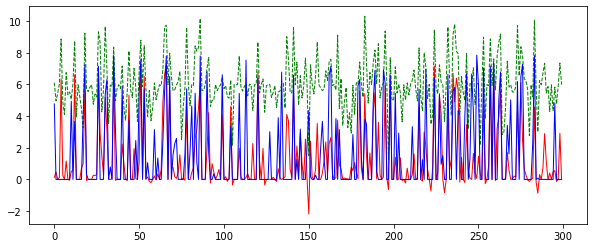

In [63]:
#plot predictions
mu,var,s,u,l=load_value('dgpfile/5node_2layers_pca_log')
y_test=load_data()[3]
y_test=np.log(y_test+1)
plt.figure(figsize=(10,4))
p=plt.plot(mu,color='r',alpha=1,lw=1)
p1=plt.plot(u,'--',color='g',lw=1)
# p1=plt.plot(l,'--',color='g',lw=1)
plt.plot(y_test,color='b',linewidth=1)

In [50]:
# log transformation
x_train,y_train,x_test,y_test=load_data()
y_train=np.log(y_train+1)
y_test=np.log(y_test+1)

In [51]:
# 2 layers, the first layer has 3 nodes, the second one has one node
layer1=[kernel(length=np.array([1]),name='sexp',input_dim=np.arange(70)),
        kernel(length=np.array([1]),name='sexp',input_dim=np.arange(70,140)),
        kernel(length=np.array([1]),name='sexp',input_dim=np.arange(140,210))]
layer2=[kernel(length=np.array([1]),name='sexp',scale_est=1,connect=np.arange(3))]
all_layer_3nodes_2layers=combine(layer1,layer2)
model_3nodes_2layers=dgp(x_train,[y_train],all_layer_3nodes_2layers)

In [52]:
model_3nodes_2layers.train(N=500)

Iteration 500: Layer 2: 100%|██████████| 500/500 [22:43<00:00,  2.73s/it]


In [53]:
#make the predictions
emu_3nodes_2layers=Construct_emulator(model_3nodes_2layers)
mu,var,s,u,l=predict(emu_3nodes_2layers,x_test,50)
np.savetxt('dgpfile/data_3nodes_2layers_log.txt',np.c_[mu,var,s,u,l])

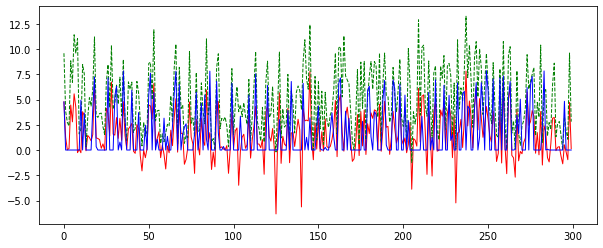

In [54]:
# plot the predictions
mu,var,s,u,l=load_value('dgpfile/data_3nodes_2layers_log.txt')
y_test=load_data()[3]
y_test=np.log(y_test+1)
plt.figure(figsize=(10,4))
p=plt.plot(mu,color='r',alpha=1,lw=1)
p1=plt.plot(u,'--',color='g',lw=1)
# p1=plt.plot(l,'--',color='g',lw=1)
plt.plot(y_test,color='b',linewidth=1)

In [55]:
# load the MASS data
x_mass=np.loadtxt('x_mass.txt')
y_mass=np.loadtxt('MASScape.txt')

In [56]:
# find 300 instances in MASS data
r=300/x_mass.shape[0]
x_test_mass,x_test,y_test_mass,y_test=train_test_split(x_mass,y_mass,test_size=1-r,random_state=42)

In [58]:
#pca transformation
x_test_mass = pca.transform(x_test_mass)

In [65]:
#make the predcitions of PCA
emu_5nodes_2layers_pca=Construct_emulator(model_5nodes_2layers_pca)
mu,var,s,u,l=predict(emu_5nodes_2layers_pca,x_test_mass,50)

<ipython-input-66-5e84b54f5b28>:5: RuntimeWarning: invalid value encountered in log
  plt.plot(np.log(y_test_mass+1),color='b',linewidth=1)


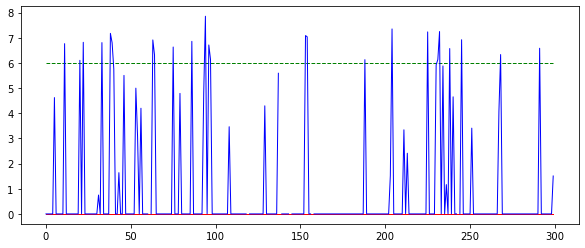

In [66]:
# plot the predictions
plt.figure(figsize=(10,4))
p=plt.plot(mu,color='r',alpha=1,lw=1)
p1=plt.plot(u,'--',color='g',lw=1)
# p1=plt.plot(l,'--',color='g',lw=1)
plt.plot(np.log(y_test_mass+1),color='b',linewidth=1)